In [2]:
!pip install -q ultralytics imutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [4]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

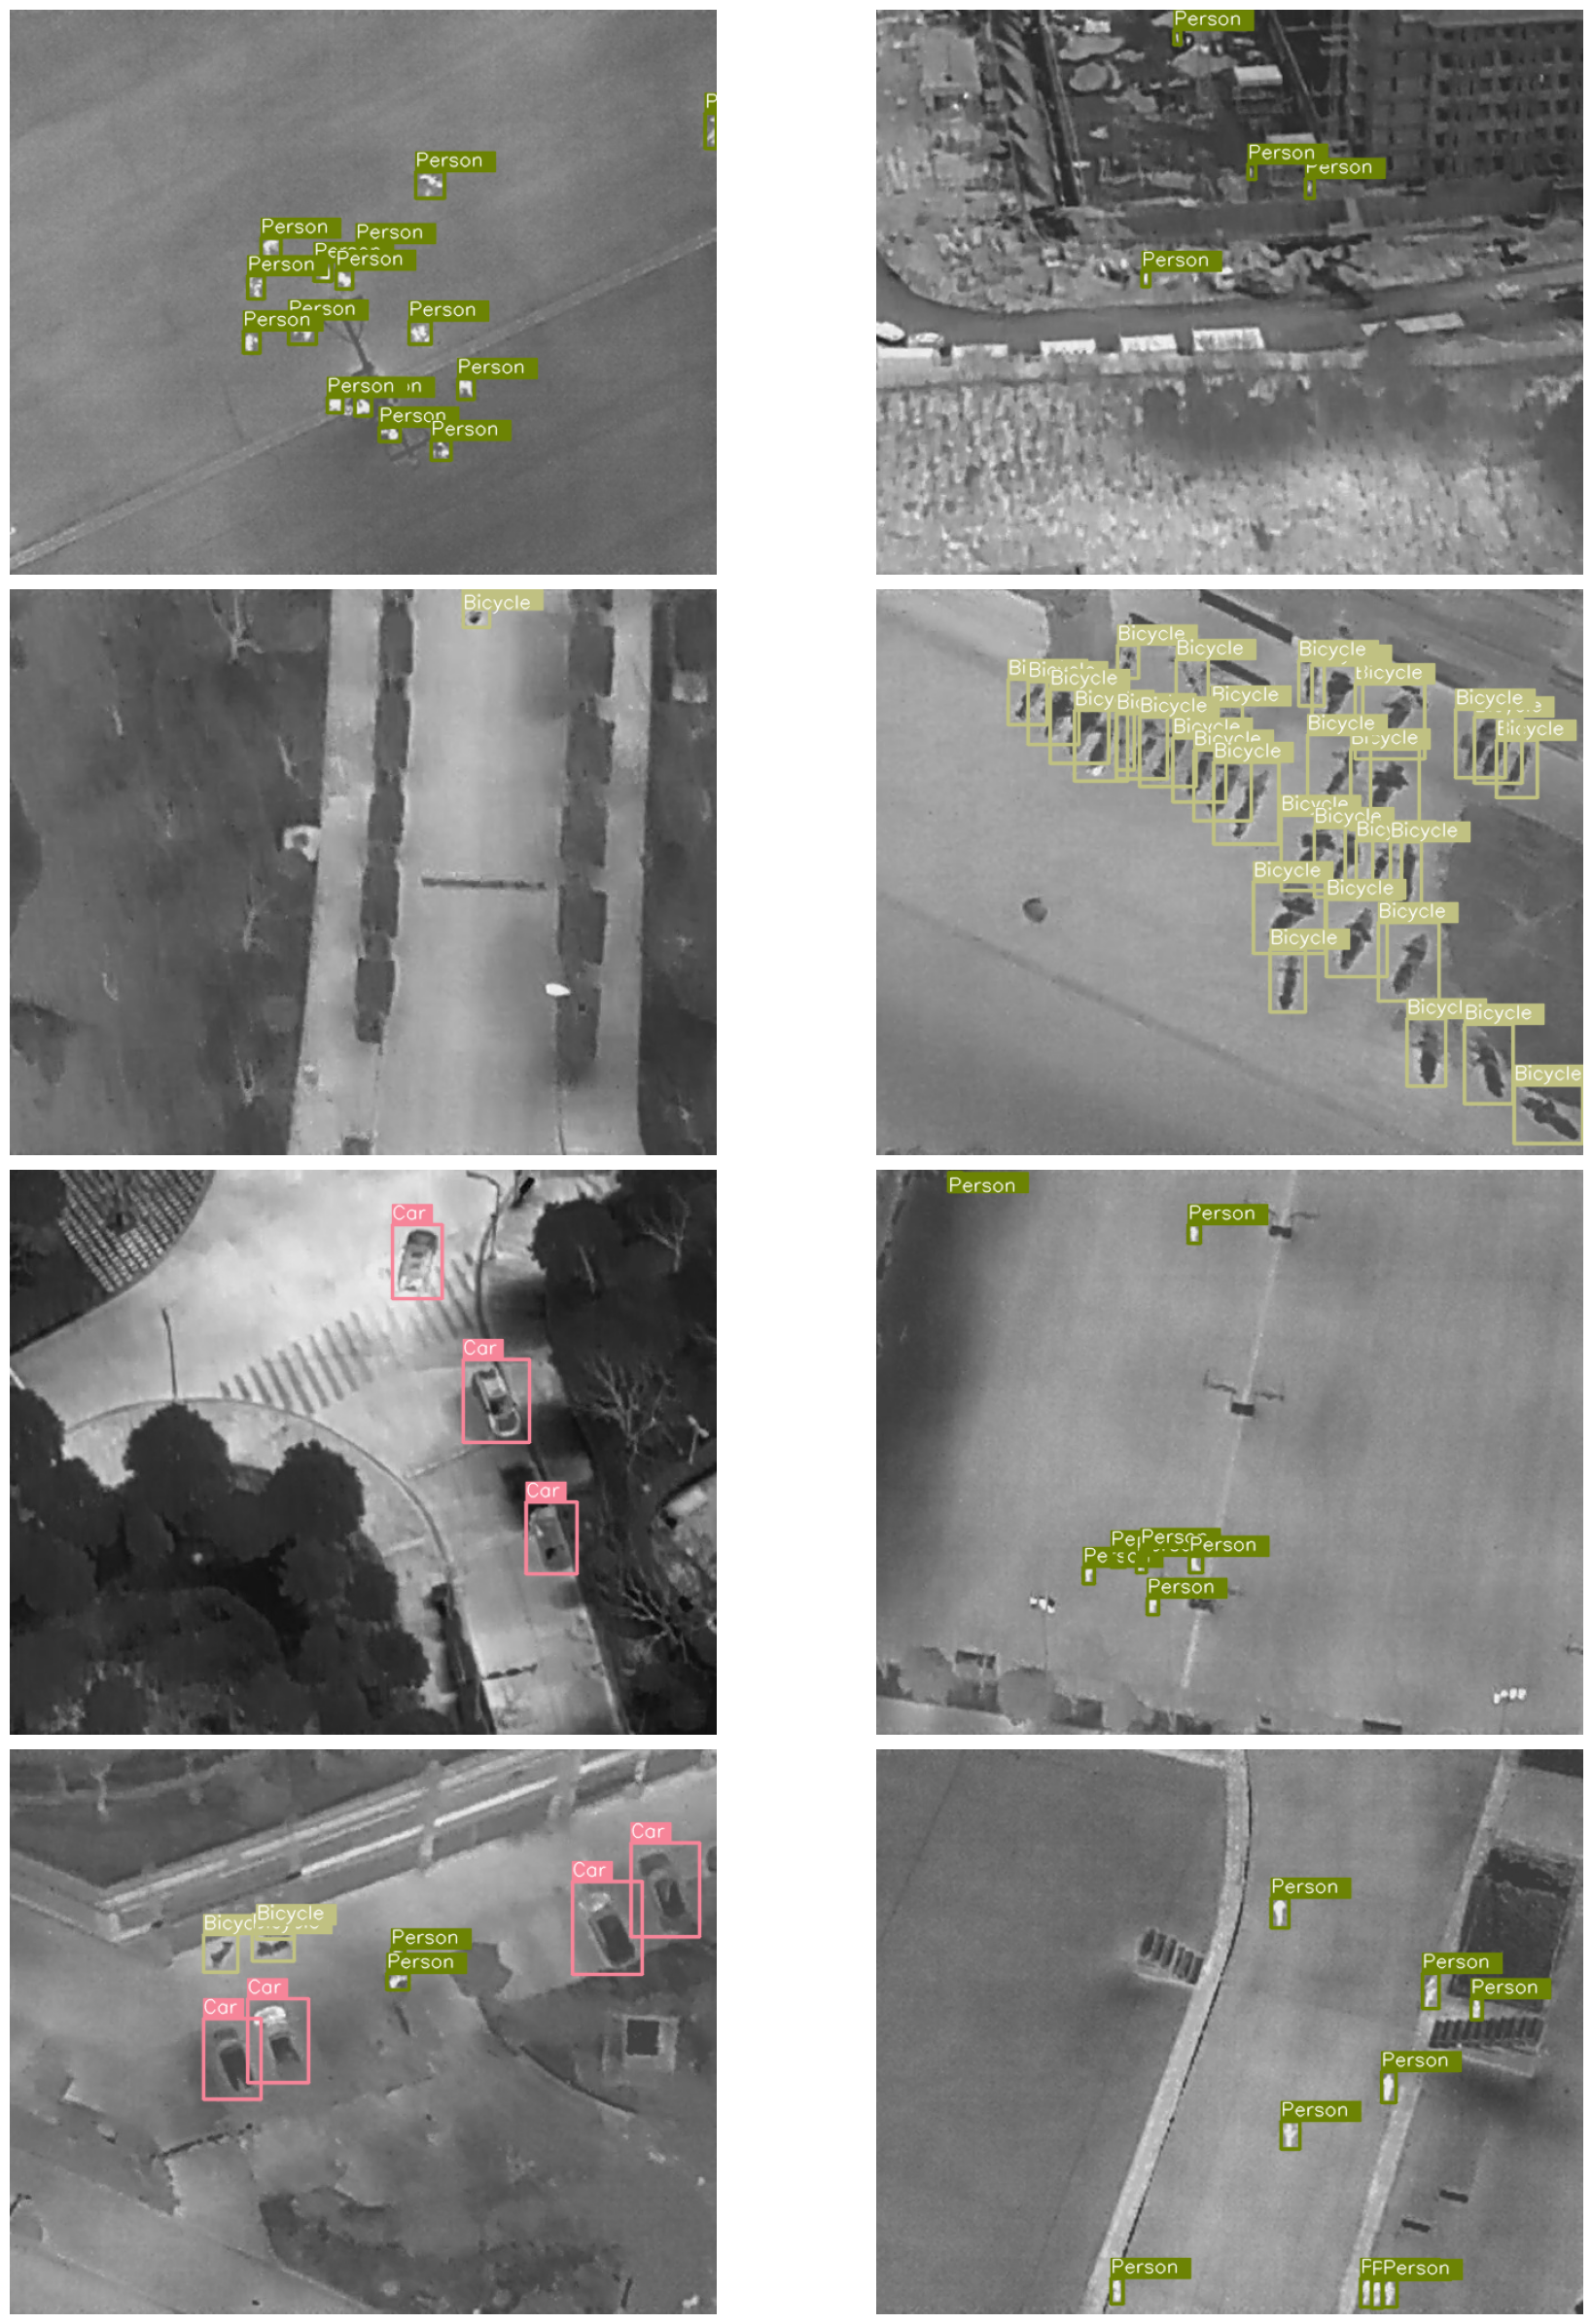

In [8]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [9]:
import yaml

# data.yaml oluşturma
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)


model_dict = {
    "nc": 5, # Số lớp của bạn (Person, Car, ...)

    # Layer 0: Load ConvNeXt-Tiny via Torchvision
    # ConvNeXt-Tiny output channels cuối cùng là 768
    "backbone": [
        # [from, repeats, module, args]
        # Args: [out_channels, model_name, weights, pretrained, stride, exportable]
        [-1, 1, "TorchVision", [768, "convnext_tiny", "DEFAULT", True, 2, True]], # backbone index 0
        [-1, 1, "nn.Identity", []], # index 1
        [-1, 1, "nn.Identity", []], # index 2

        # ------ P3 Branch (Target: 256 channels at 80 x 80)
        # ConvNeXt-Tiny Stage 2 (P3) có 192 channels.
        # Index 4 thường là vị trí của Stage 2 trong biến 'features' của TorchVision ConvNeXt
        [0, 1, "Index", [192, 4]], # Trích xuất đặc trưng P3 (192 ch) -> index 3
        [-1, 1, "Conv", [256, 1, 1]], # Ép từ 192 lên 256 channels chuẩn của YOLO
        [-1, 1, "nn.Identity", []], # Đánh dấu đây là backbone P3 (index 5)

        # --------- P4 Branch (Target: 512 channels at 40 x 40)
        # ConvNeXt-Tiny Stage 3 (P4) có 384 channels.
        # Index 6 là Stage 3
        [0, 1, "Index", [384, 6]], # Trích xuất đặc trưng P4 (384 ch) -> index 6
        [-1, 1, "Conv", [512, 1, 1]], # Ép từ 384 lên 512 channels
        [-1, 1, "nn.Identity", []], # Đánh dấu đây là backbone P4 (index 8)

        # ------------------------- P5 Branch (Target: 1024 channels at 20 x 20)
        # ConvNeXt-Tiny Stage 4 (P5) có 768 channels.
        # Index 8 là Stage 4
        [0, 1, "Index", [768, 8]], # Trích xuất đặc trưng P5 (768 ch) -> index 9
        [-1, 1, "Conv", [1024, 1, 1]], # Ép từ 768 lên 1024 channels -> index 10
        [-1, 1, "SPPF", [1024, 5]] # SPPF block -> index 11
        
    ],
    "head": [
        [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
        [[-1, 8], 1, "Concat", [1]], # Nối với P4 (lấy từ index 8 ở trên)
        [-1, 3, "C2f", [512, True]], # index 14

        [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
        [[-1, 5], 1, "Concat", [1]], # Nối với P3 (lấy từ index 5 ở trên)
        [-1, 3, "C2f", [256, True]], # index 17 (Output P3)

        [-1, 1, "Conv", [256, 3, 2]],
        [[-1, 14], 1, "Concat", [1]], # Nối lại với P4 đã xử lý
        [-1, 3, "C2f", [512, True]], # index 20 (Output P4)

        [-1, 1, "Conv", [512, 3, 2]],
        [[-1, 11], 1, "Concat", [1]], # Nối lại với P5 (lấy từ index 11 - SPPF)
        [-1, 3, "C2f", [1024, True]], # index 23 (Output P5)

        [[17, 20, 23], 1, "Detect", ["nc"]] # Detect dựa trên 3 đầu ra cuối
    ]
}

with open("yolov8-custom.yaml", "w") as f:
    yaml.dump(model_dict, f, sort_keys=False)
   

In [10]:
from ultralytics import YOLO

yolo_efficientnet_model = YOLO('/kaggle/working/yolov8-custom.yaml')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 235MB/s] 


In [11]:
yolo_efficientnet_train = yolo_efficientnet_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 16)

Ultralytics 8.3.231 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/yolov8-custom.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460      0.796      0.781      0.798      0.534
                Person        171       1168      0.862      0.896      0.913      0.522
                   Car        136        719       0.94      0.984      0.989      0.778
               Bicycle         53        554      0.831      0.904      0.918      0.566
          OtherVehicle          9         12      0.998      0.833      0.847      0.649
              DontCare          5          7       0.35      0.286      0.323      0.155
Speed: 0.1ms preprocess, 42.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [12]:
best_efficientnet_model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/detect/train4/weights/best.pt'

In [ ]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [ ]:
!zip -r /kaggle/working/runs.zip runs/

In [ ]:
!ls -lh /kaggle/working/


# Inference on Test Images


In [ ]:
results = best_efficientnet_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)

In [ ]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




In [ ]:
show_random_result(results)

In [ ]:
show_random_result(results)

In [ ]:

show_random_result(results)

In [ ]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [ ]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [ ]:
!ls runs/detect

In [ ]:
success = best_efficientnet_model.export(format="onnx")  # export the model to ONNX format
success